#### Installations

In [0]:
# !pip install torch

In [0]:
# !pip install -U textblob
# !python -m textblob.download_corpora

In [0]:
# ! wget -nH -r -np -P data/tmp http://files.fast.ai/models/wt103/
# !python -m spacy download en

In [0]:
# !pip install yellowbrick
# !pip install textacy
# !pip install cld2-cffi

### Setup

#### Imports

In [0]:
# On sucess - you get no output
import os
from google.colab import drive
import pandas as pd
import numpy as np
from collections import defaultdict
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import RadiusNeighborsClassifier
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import pickle
# import torch
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassPredictionError

from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()


seed = 666

#### Mount drive and set path

In [0]:
drive.mount('/content/gdrive')
print(os.chdir('gdrive/My Drive/Colab Notebooks/project0'))
print(os.listdir())

# !mkdir -p 'gdrive/My Drive/Colab Notebooks/Cifar10/project0'
# print(os.listdir('gdrive/My Drive/Colab Notebooks'))
# print(os.listdir('data/FEIII 2018 Training Data v1/TRDF data'))



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
None
['data', 'images', 'project0.ipynb']


#### Paths, loads and saves

In [0]:
from pathlib import Path
PATH = Path('data')
training_prediction_edges_path = Path('data/FEIII 2018 Training Data v1/TRDF data/TRDF_edges_training_CIK-to-CIK.csv')
original_10_sec_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Role_FE_Reference_modified.csv')
seed_10_sec_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Seed_Role_FE_Reference_modified.csv')
unlabeled_10_sec_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Unlabeled_Role_FE_Reference_modified.csv')
seed_test_10_sec_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Seed_test_Role_FE_Reference_modified.csv')
# wikitext103_path = PATH/'tmp'/'models'/'wt103'
# PRE_LM_PATH = wikitext103_path/'fwd_wt103.h5'
models_path = PATH/'tmp'/'my_models'
unlabeled_df_final_all_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Unlabeled_Role_FE_Reference_modified_final_prediction_qith_info.csv')
unlabeled_df_final_path = Path('data/FEIII 2018 Training Data v1/SEC 10-K Relationships/Unlabeled_Role_FE_Reference_modified_final_prediction_formated.csv')


In [0]:
def save_df(df,path):
  df.to_csv(path, sep=',', encoding="utf-8-sig", index=False)

def load_df(path=seed_10_sec_path):
  return pd.read_csv(path, sep=',', encoding="utf-8-sig")

save_seed = save_seed_features_data = lambda: seed_data.to_csv(seed_10_sec_path, sep=',', encoding="utf-8-sig", index=False)
get_seed_data = lambda: pd.read_csv(seed_10_sec_path, sep=',', encoding="utf-8-sig")

In [0]:
def save_model(name):
  filename = models_path/'{}_model.sav'.format(name)
  pickle.dump(visualizer[name], open(filename, 'wb'))

## Pre-proccessing

### Arrange data

#### Helper functions

TODO: check if gets more than 1 prediction per i,k (using only first row now with values[0])

In [0]:
# def get_y(i,k):
#   df = training_y_edges.set_index(['SOURCE', 'DESTINATION'])
#   if (i,k) in list(df.index.values):
#     return df.loc[(i,k)]['y'].values[0]
#   if (k,i) in list(df.index.values):
# #     print(df.loc[(k,i)]['y'])
#     return df.loc[(k,i)]['y'].values[0]
#   return 3

# training_y_edges = pd.DataFrame(pd.read_csv(training_prediction_edges_path, delimiter=',', encoding="utf-8-sig"), columns=['SOURCE', 'DESTINATION','PREDICATE'])
# training_y_edges['y'] = training_y_edges['PREDICATE']== 'isCompetitorOf'
# print(training_y_edges[:10])
# print(get_y(791206,713676))
# print(get_y(8565,92230))

In [0]:
# CIK1 = 'FILER_CIK'
# CIK2 = 'MENTIONED_FINANCIAL_ENTITY_CIK'

# def find_prediction(x):
#   if (CIK1 not in x.index): print("KeyError CIK1") 
#   if (CIK2 not in x.index): print("KeyError CIK2")
#   i,k = x[[CIK1,CIK2]].values
#   if pd.isnull(i) or pd.isnull(k): return 4
# #   print(int(i),int(k))
#   y = get_y(int(i),int(k))
#   return y

I used 4 categories for the prediction - 0 for non competitors, 1 for competitors, 3 for unknown prediction and 4 for missing cik's

we have:

3-Unknown relationship       13810

4-Missing at least one of the cik's        13551

True       941

False      192

Step 1: add 'PREDICATE' column to feature data 

In [0]:
# feature_data = pd.read_csv(original_10_sec_path, delimiter=',', encoding="utf-8-sig")

# feature_data['PREDICATE'] = feature_data.apply(find_prediction,axis=1)
# print(feature_data['PREDICATE'].value_counts())
print(feature_data.columns)

Index(['Unnamed: 0', 'DOCUMENT_TYPE', 'FILENAME', 'FILER_NAME', 'FILER_CIK',
       'FILING_INTERVAL', 'FILING_DATE', 'MENTIONED_FINANCIAL_ENTITY\tROLE',
       'FIVE_SENTENCES', 'MENTIONED_FINANCIAL_ENTITY_CIK',
       'MENTIONED_FINANCIAL_ENTITY_GROUP_IDENTIFIER', 'PREDICATE'],
      dtype='object')


Step 2: devide feature_data to seed and unlabeled

In [0]:
# is_unknown_prediction = feature_data['PREDICATE']=='3'
# features_data_unlabeled = feature_data.loc[is_unknown_prediction]
# features_data_unlabeled.to_csv(unlabeled_10_sec_path, sep=',', encoding="utf-8-sig")

True     941
False    192
Name: PREDICATE, dtype: int64


#### Step 2.5

In [0]:
# is_known = feature_data.PREDICATE.isin(['True','False'])
# seed_data = feature_data.loc[is_known]
# print(seed_data['PREICATE'].value_counts())
# seed_data = seed_data[['FILER_CIK','MENTIONED_FINANCIAL_ENTITY_CIK','PREDICATE','FIVE_SENTENCES']]
# print(features_data_unlabeled['PREDICATE'].value_counts())
# save_seed_features_data()

Step 3: devide seed to training and validation 

In [0]:
seed_data = get_seed_data()
print(seed_data.head())
# train, test = train_test_split(seed_data, test_size=0.15)
# save_df(train,seed_10_sec_path)
# save_df(test,seed_test_10_sec_path)

## SpaCy

Apply SpaCy's nlp function and save vector to new column

In [0]:
LOG_NLP = True
def apply_nlp(df):
  if 'FIVE_SENTENCES' in df.columns:
    df['spaCy'] = df.FIVE_SENTENCES.apply(lambda x:nlp(x))
    if LOG_NLP: print("spaCy column added")
    df['spaCy_mean_vec'] = df.spaCy.apply(lambda x:x.vector)
    if LOG_NLP: print("spaCy_mean_vec column added")
  else:
    print("DataFrame doesn't contain five sentences")
  return df
#   save_seed()

In [0]:
# seed_data['spaCy'] = seed_data.FIVE_SENTENCES.apply(lambda x:nlp(x))
# seed_data['spaCy_mean_vec'] = seed_data.spaCy.apply(lambda x:x.vector)
# save_seed()

Just some debuging

In [0]:
# tmp['spaCy_mean_vec'] = tmp.spaCy_mean_vec.values.tolist()
# print(type(seed_data['spaCy_mean_vec'].values[0]))
# print(seed_data.spaCy_mean_vec[:5])
print(seed_data.spaCy_mean_vec[4].size)

384


## Training

In [0]:
def create_models():
  models = {}
  models['svclassifier'] = SVC(kernel='linear') 
  models['bayes'] = GaussianNB()
  models['RadiusNeighborsClassifier'] = RadiusNeighborsClassifier(radius=2.0,outlier_label='unknown')
  models['logistic'] = LogisticRegression()
  models['linSVC'] = LinearSVC(random_state=0, tol=1e-5)
  models['randomForest'] = RandomForestClassifier()
  return models

In [0]:
# ORIGINAL
classsifier = {}
def viz_model(name_list, support=True):
  # Instantiate the classification model and visualizer
  if isinstance(name_list,str): name_list = [name_list]
  for name in name_list:
    classsifier[name] = ClassificationReport(models[name], support=support)

    classsifier[name].fit(X_train, y_train)  # Fit the visualizer and the model
    classsifier[name].score(X_val, y_val)  # Evaluate the model on the validation data
    g = classsifier[name].poof()             # Draw/show/poof the data

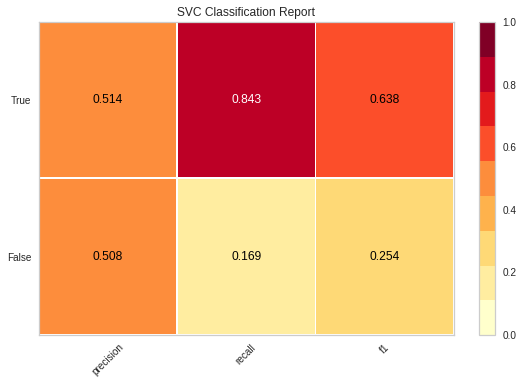

In [0]:
def dummy_true_classifier():
    y_true = np.random.choice([0, 1], size=(len(X_val)))
    dummy_classsifier = ClassificationReport(models['svclassifier'])
    dummy_classsifier.fit(X_train, y_train)
    dummy_classsifier.score(X_val, y_true)  # Evaluate the model on the validation data
    g = dummy_classsifier.poof()             # Draw/show/poof the data
dummy_true_classifier()

## Visualizations

### KPI's

In [0]:
def show_balance_viz():
  visualizer = ClassBalance(labels=['True','False'])
  visualizer.fit(y_train,y_val)
  g = visualizer.poof()
  
show_balance_viz()

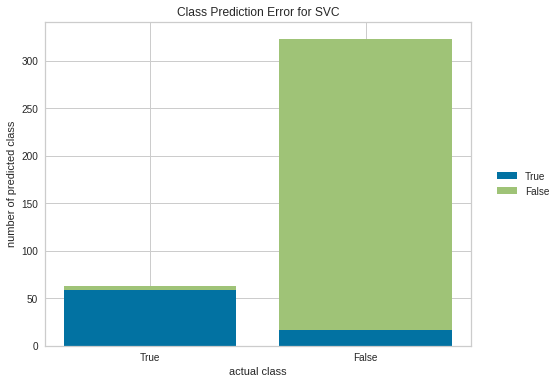

In [0]:
predictionErr = {}
def viz_model_error(name_list):
  # Instantiate the classification model and visualizer
  if isinstance(name_list,str): name_list = [name_list]
  for name in name_list:
    predictionErr[name] = ClassPredictionError(models[name], classes=['True','False'])

    predictionErr[name].fit(X_train, y_train)
#     y_val = np.random.choice([0, 1], size=(len(X_val)))
    predictionErr[name].score(X_val, y_val) 
    g = predictionErr[name].poof()           
viz_model_error(['svclassifier'])

In [0]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

learning_curve = {}
def viz_learning_curve(name_list):
  if isinstance(name_list,str): name_list = [name_list]
  for name in name_list:
    learning_curve[name] = LearningCurve(models[name], cv=StratifiedKFold(12), train_sizes=np.linspace(0.3, 1.0, 10),scoring='f1_weighted', n_jobs=4)
    learning_curve[name].fit(X_train, y_train)
    g = learning_curve[name].poof()
viz_learning_curve([top,'svclassifier','RadiusNeighborsClassifier','randomForest'])

### spacy

In [0]:
text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

# doc = nlp(text)
# doc = seed_data.spaCy[1]
# colors = {'ORG': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', 'GPE':'linear-gradient(90deg, #ffe9af, #ffdd84)',
#           'CARDINAL':'linear-gradient(90deg, #3c5c68, #93d5ed)'}
# options = {'ents': ['ORG','CARDINAL','GPE'], 'colors': colors}
displacy.render(doc, style='ent', options=options, jupyter=True)

## Unsupervised Prediction for Unlabeled

In [0]:
# unlabeled_df = load_df(unlabeled_10_sec_path)

In [0]:
def predict(unlabeled_df):
  unlabeled_df['predicted_label'] = 0
  unlabeled_df = unlabeled_df[['FILER_CIK','MENTIONED_FINANCIAL_ENTITY_CIK','predicted_label','FIVE_SENTENCES']]
  unlabeled_df = apply_nlp(unlabeled_df)
  
  X_unlabeled_ = unlabeled_df['spaCy_mean_vec']
  unlabeled_df['predicted_label'] = classifier['svclassifier'].predict(X_unlabeled.values.tolist())
  unlabeled_df_final = unlabeled_df[['FILER_CIK','MENTIONED_FINANCIAL_ENTITY_CIK','predicted_label']]
  return unlabeled_df, unlabeled_df_final

In [0]:
unlabeled_df, unlabeled_df_final = predict(unlabeled_df)

In [0]:
save_df(unlabeled_df,unlabeled_df_final_all_path)
save_df(unlabeled_df_final,unlabeled_df_final_path)


In [0]:
# TODO: calc predictions
# TODO: figure how to save the model
# TODO: make a pipeline for production

## Auomate

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


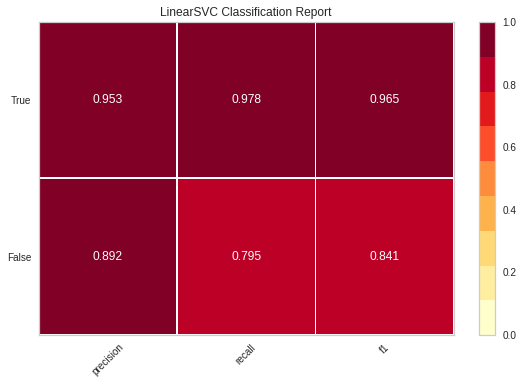

In [0]:
# seed_data = get_seed_data()
# seed_data = apply_nlp(seed_data)
X_train, X_val, y_train, y_val = train_test_split(seed_data.spaCy_mean_vec.values.tolist(), seed_data.PREDICATE.values, test_size = 0.40)
# models = create_models()
top = 'linSVC'
X = seed_data.spaCy_mean_vec.values.tolist()
y = seed_data.PREDICATE.values
viz_model([top],False)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


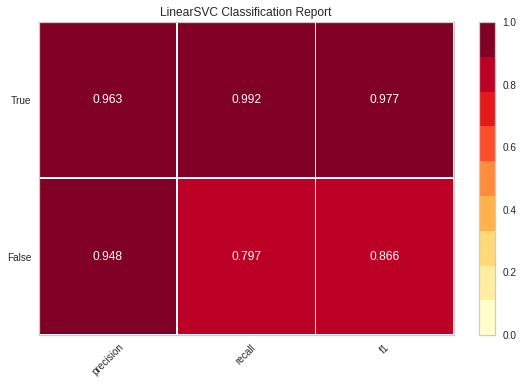

In [0]:
X_train, X_val, y_train, y_val = train_test_split(seed_data.spaCy_mean_vec.values.tolist(), seed_data.PREDICATE.values, test_size = 0.45)
X = seed_data.spaCy_mean_vec.values.tolist()
y = seed_data.PREDICATE.values
viz_model([top],False)